# CS5228 Assignment 2a - Tree-Based Models (50 Points)

Hello everyone, this assignment notebook covers the Tree-Based Models as part of the topic Classification & Regression. There are some code-completion tasks and question-answering tasks in this answer sheet. For code completion tasks, please write down your answer (i.e. your lines of code) between sentences that "your code starts here" and "your code end here". The space between these two lines does not reflect the required or expected lines of code :). For answers in plain text, you can refer to [this Markdown guide](https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd) to customize the layout (although it shouldn't be needed) 

**Important:** 
* Remember to save this Jupyter notebook as A1a_YourNameInLumiNUS_YourNUSNETID.ipynb
* Submission deadline is October 17th, 11.59 pm (together with A1b)

Please also add your nusnet and student id also in the code cell below. This is just to make any identification of your notebook doubly sure.

In [1]:
student_id = 'A0236597M'
nusnet_id = 'e0744016'

Here is an overview over the tasks to be solved and the points associated with each task. The notebook can appear very long and verbose, but note that a lot of parts are there provide additional explanations, documentation, or some discussion. The code and markdown cells you are a supposed to complete are well marked, but you can use the overview below to double-check that you covered everything.

* **1 Decision Tree Basics (20 Points)**
    * 2.1 Understanding Decision Trees (10 Points)
        * 2.1a) 3 Points
        * 2.1b) 3 Points
        * 2.1c) 4 Points
    * 2.2 Bagging and Feature Sampling (10 Points)
        * 2.2a) 2 Points
        * 2.2b) 2 Points
        * 2.2c) 6 Points
* **2 Gradient-Boosted Tree Regressor (20 Points)**
    * 2.1 Implementing a Decision Stump Regressor (12 Points)
        * 2.1a) Calculating the RSS Score for a Split (2 Points)
        * 2.1b) Calculating the Set of Thresholds (4 Points)
        * 2.1c) Finding the Best Split (4 Points)
        * 2.1d) Predicting Output Values (2 Points)
    * 2.2 Implementing Gradient-Boosting (8 Points)
        * 2.1a) Training the Gradient-Boosted Regressor (6 Points)
        * 2.1b) Predicting Output Values (2 Points)
* **3 Evaluation of Tree-Based Models (10 Points)**
    * 3.1 Data Preprocessing (2 Points)
    * 3.2 Evaluation using K-Fold Cross Validation (8 Points)
        * 3.2a) 5 Points
        * 3.2b) 3 Points

## Setting up the Notebook

**Important:** In this notebook, most code-completion tasks require to edit the file `src/tree.py`. The code cell below ensures that any change to the file (after saving) will cause a reload in this notebook. So there's no need to "manually" import the code after every change. Way more convenient.

In [2]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# This will automatically reload src/dtree.py every time you make changes and save the file
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib notebook

The following statements contain all the packages need to complete the notebook.

In [4]:
import numpy as np
import pandas as pd

from src.utils import plot_validation_results, plot_scores
from src.tree import MyDecisionStumpRegressor, MyGradientBoostedRegressor

from sklearn.model_selection import train_test_split, cross_validate

# Only used to compare your own implementation
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor

## 2. Decision Trees Basics (20 Points)

### 2.1 Understanding Decision Trees (10 Points)

The plot below shows a toy dataset of 100 data points for a binary classification task. Each data point belongs either to Class Red (big dots) or Blue (small dots); the different dot sizes are only there to accommodate color-blind students, if needed.

<img src="data/a2-knn-data.png">

Now imagine you train a full Decision Tree by running `sklearn.tree.DecisionTreeClassifier` over this dataset without any early stopping, pruning, etc. Note that this implementation of a Decision Tree performs only binary splits.

**2.1 a) How many nodes (both internal and leaf nodes) will the Decision Tree have? (3 Points)** Briefly explain how you derived this number!

**Your Answer:**

I think there will be 13 nodes, as shown in the picture below.  
My segmentation strategy is: every time a line is drawn to split the points, try to keep at least one branch with the same color.  
step 1: x<=3  
step 2: y>=4  
step 3: x<=1  
step 4: y<=6  
...

<img src="data/13-nodes.png">

You are no allowed to flip the labels of **two a pairs** of data points. To specify a data point you can use $(x,y)$ coordinates. For example $(1,1)$ references to bottom-left data point, and $(10,10)$ references to top-right data point. To Given an example indicating a single flip of labels between 2 data points:
 
* $(1,1) \Leftrightarrow (1,10)$: flips labels of top-left data point with top-left data point

After the flipping labels, the number of Red and Blue dots are obviously still the same. Now you train another Decision Tree and count the number of nodes.
 
**2.1 b) Which 2 pairs of data points do you pick and flip the labels to minimize the number of nodes in the new resulting Decision Tree? (3 Points)** Briefly explain your answer and give the new total number of nodes in the Decisions Tree !
 
**Your Answer:**

The main idea of reducing the number of nodes is to bring the same colors together.
* $(7,10) \Leftrightarrow (8,8)$
* $(1,4) \Leftrightarrow (10,7)$

After flipping, there will be 9 nodes in total.

<img src="data/flip.png">

The example plot above is a $10\times 10$ grid of data points. Now assume a $m\times n$ grid of data points with $m\geq 2$ and $n\geq 2$. From 1.1a) and 1.1b) you already got a basic idea how the distribution of labels affects the size of the Decision Tree in terms of the number of nodes in the tree (again, without any early stopping, pruning, etc.). Now we are looking at the worst case.
 
**2.1 c) Given $m\times n$ grid of data points, which assignment the labels yields the Decision Tree with the most number of nodes? (4 Points)** Briefly explain your answer and provide a formula that expresses the number of nodes in terms of $m$ and $n$!
 
**Your Answer:**

Spread the data as much as possible, then every single point will become a node.  
The assignments can be like this: `[[0,1,0,1,0...],[1,0,1,0,1...],[0,1,0,1,0...]...]`  
`total_number_of_nodes = m*n`


### 2.2 Bagging & Feature Sampling (8 Points)

In the lecture, we discussed the limitations of individual Decision Trees, which motivated the notion of Tree Ensembles. In a nutshell, a Tree Ensemble trains multiple Decision Trees with in the same classifier and regressor to reduce variance and improve accuracy. The first approach towards creating Tree Ensembles was to train multiple Decision Trees over different samples of the data:

* **Bagging (Bootstrap Aggregation):** Sample a new dataset $D_i$ sampled from $D$ uniformly and with replacement ($|D_i| = |D|$)
* **Feature Sampling:** For a given dataset $D$ with $d$ features, consider only a random subset of features of size $m$ with $m<d$.

Combining Bagging and Feature Sampling is the underlying idea of *Random Forests*. In this task, you will explore the effects of Bagging and Bagging+FeatureSampling

We use the very basic [IRIS](https://archive.ics.uci.edu/ml/datasets/iris) dataset: it's small and clean, and has only numerical features. The dataset contains 3 classes of 50 instances each, where each class refers to a type of iris plant.

##### Load Example Data

In [5]:
df = pd.read_csv('data/a2-iris.csv')

# Convert the species name to numerical categories 0, 1, 2
df['species'] = pd.factorize(df['species'])[0]

# Show the first 5 rows
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


##### Convert to NumPy Arrays

In [6]:
data = df.to_numpy()

X = data[:,0:4]
y = data[:,4].astype(int)

print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (150, 4)
Shape of y: (150,)


**2.2 a) Implement method `create_boostrap_sample()` to generate a bootstrap sample for a given dataset! (2 Points)** The input dataset is represented by feature array `X` and array `y` contain the class labels (classification) or output values (regression).

**Important:** Avoid using loops in the parts of the codes you have to complete. As usual, let NumPy by your friend :). If you use loops but the results is correct, there will be some minor deduction of points.

In [7]:
def create_boostrap_sample(X, y):
    X_boostrap, y_boostrap = None, None

    N, d = X.shape
    
    #########################################################################################
    ### Your code starts here ###############################################################
    indices = np.random.choice(N, N)
    X_boostrap = X[indices]
    y_boostrap = y[indices]
    
    
    ### Your code ends here #################################################################
    #########################################################################################
    
    return X_boostrap, y_boostrap


X_boostrap, y_boostrap = create_boostrap_sample(X, y)

print('Shape of X_boostrap: {}'.format(X_boostrap.shape))
print('Shape of y_boostrap: {}'.format(y_boostrap.shape))

Shape of X_boostrap: (150, 4)
Shape of y_boostrap: (150,)


The shapes of `X_boostrap` and `y_boostrap` should of course be the same as the shapes of `X` and `y`.

**2.2 b) Implement method `perform_feature_sampling()`! (2 Points)** The input is feature array `X`; use the common approach introduced in the lecture for calculating the number of sampled features. Apart from the new dataset `X_sample` the method also returns the indices of the selected features; we need those for the next task

**Important:** Avoid using loops in the parts of the codes you have to complete. If you use loops but the results is correct, there will be some minor deduction of points.

In [8]:
def perform_feature_sampling(X):
    N, d = X.shape
    
    X_feature_sampled, selected_indices = None, None
    
    #########################################################################################
    ### Your code starts here ###############################################################    
    selected_indices = np.random.choice(d, round(d**0.5), replace=False)
    X_feature_sampled = X[:,selected_indices]
    
    
    ### Your code ends here #################################################################
    #########################################################################################    
    
    return X_feature_sampled, selected_indices
    
X_sampled, selected_indices = perform_feature_sampling(X)

print('Shape of X_sampled: {}'.format(X_sampled.shape))
print('Selected indices: {}'.format(selected_indices))

Shape of X_sampled: (150, 2)
Selected indices: [2 1]


`X_sampled` has to contain the same number of data samples as `X`, but with less features than `X`. The number of selected indices should of course be reflected in the shape of `X`. For example, if the the shape of `X` is $(n, m)$, the there should be $m$ selected indices.

**Comparing Bagging and Bagging+FeatureSampling.** Intuitively, different sampled dataset will yield different Decision Trees, not only regarding the accuracy, but also how the Decision Trees will "look like". In the following, we train a set of Decision Trees (using the Decision Tree implementation from `sklearn`) based on different dataset samples.

First we consider only **Bagging**. Just run the code cell below; nothing for you to implement here.

In [9]:
for _ in range(20):
    # Create a new bootstrap sample
    X_t, y_t = create_boostrap_sample(X, y)
    
    # Train a Decision Tree using bootstrap sample
    classifier = DecisionTreeClassifier().fit(X_t, y_t)
    
    # Print core features of trained Decision Tree
    # (feature index of root node, total of number in Decision Trr)
    print('Feature index of root node: {}, #nodes: {}'
          .format(classifier.tree_.feature[0], classifier.tree_.node_count))

Feature index of root node: 3, #nodes: 13
Feature index of root node: 3, #nodes: 7
Feature index of root node: 2, #nodes: 17
Feature index of root node: 2, #nodes: 11
Feature index of root node: 2, #nodes: 15
Feature index of root node: 2, #nodes: 11
Feature index of root node: 3, #nodes: 13
Feature index of root node: 2, #nodes: 7
Feature index of root node: 3, #nodes: 11
Feature index of root node: 3, #nodes: 9
Feature index of root node: 3, #nodes: 15
Feature index of root node: 3, #nodes: 9
Feature index of root node: 2, #nodes: 13
Feature index of root node: 2, #nodes: 15
Feature index of root node: 3, #nodes: 9
Feature index of root node: 2, #nodes: 13
Feature index of root node: 2, #nodes: 13
Feature index of root node: 3, #nodes: 7
Feature index of root node: 3, #nodes: 15
Feature index of root node: 2, #nodes: 13


Now we consider **Bagging+FeatureSampling**. This means, we almost built a Random Forest. Just run the code cell below; nothing for you to implement here.

In [10]:
for _ in range(30):
    X_t, y_t = create_boostrap_sample(X, y)
    X_t, selected_indices = perform_feature_sampling(X_t)
    
    classifier = DecisionTreeClassifier().fit(X_t, y_t)
    
    print('Feature index of root node: {}, #nodes: {} (selected indices: {})'
          .format(selected_indices[classifier.tree_.feature[0]], classifier.tree_.node_count, selected_indices))

Feature index of root node: 2, #nodes: 11 (selected indices: [3 2])
Feature index of root node: 2, #nodes: 23 (selected indices: [2 1])
Feature index of root node: 3, #nodes: 23 (selected indices: [3 0])
Feature index of root node: 2, #nodes: 21 (selected indices: [1 2])
Feature index of root node: 0, #nodes: 67 (selected indices: [1 0])
Feature index of root node: 2, #nodes: 17 (selected indices: [2 0])
Feature index of root node: 2, #nodes: 15 (selected indices: [2 0])
Feature index of root node: 2, #nodes: 21 (selected indices: [2 0])
Feature index of root node: 2, #nodes: 21 (selected indices: [0 2])
Feature index of root node: 2, #nodes: 15 (selected indices: [2 1])
Feature index of root node: 3, #nodes: 21 (selected indices: [3 0])
Feature index of root node: 2, #nodes: 15 (selected indices: [2 0])
Feature index of root node: 3, #nodes: 19 (selected indices: [3 0])
Feature index of root node: 2, #nodes: 23 (selected indices: [2 1])
Feature index of root node: 3, #nodes: 27 (selec

**2.2 c) Interpret the result! (6 Points)** When comparing the resulting Decision Trees when using only **Bagging** and **Bagging+FeatureSampling** you must have observed several difference. List all your observation together with a brief explanation for the observed difference. What insights into the dataset can you gain from your observations?

**Your Answer:**

1. Compared to boostrap sampling combined with feature sampling, the boostrap sampling has a less influence on the selection of the root node, it's always 2 or 3 in the end. The main reason is that most bagged trees will use strong predictors at the top. Also, the total number of nodes ranges from 7 to 17, which is relatively stable compared to the combination of bagging and feature sampling. With similar root node and total number of nodes, most bagged trees will look very similar.  
2. However, the choice of root node for boostrap sampling combined with feature sampling differs greatly. Also, the total number of nodes varies greatly from 7 to 73. So the trees often look very different in the end.

------------------------------------------------------------------------------

## 2 Gradient-Boosted Tree Regressor

Your last task will be to implement a Gradient-Boosted Tree Regressor as covered in the lecture. But not to worry, this may only sound more difficult than it actually is, and we will guide you through this process step by step. We also keep things simple by assuming that all input features are numerical values.

Fundamentally, we can split the implementation into 2 subtasks.

* **Weak Learner:** Gradient Boosting builds a Strong Learner by combining a series of Weak Learners. For this, we consider a "Decision Stump", i.e., a Decision Tree with only one split and therefore a height of 1.
* **Gradient Boosting:** With the Decision Stump in place, you can implement Gradient Boosting as shown in the lecture.

All the implementation is done in file `src/tree.py`.

### 2.1 Implementing a Decision Stump Regressor

A Decision Stump is nothing else but a Decision Tree with only one split. This means that the only task here is to find the one best split; there is not need to continue recursively splitting child nodes like for a (full) Decision Tree trained to be a Strong Learner.

For finding the best split, we need three things
* A scoring method to quantify how good a split is
* A method to find all meaningful thresholds for defining a split (given a list of features values; here all numerical)
* A method to actually find the best split using the previous 2 methods

#### 2.1 a) Calculating the RSS Score for a Split (2 Points)

Let's first define some arrays with random output values to test your implementation

In [11]:
y1 = np.array([0.3, 0.2, 0.2, 0.25, 0.2, 0.3, 0.35, 0.2])
y2 = np.array([0.1, 0.8, 0.9, 0.3, 0.5, 0.6, 0.7, 0.7])
y3 = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

Recall from the lecture, that the RSS score of a split is defined as:

$$RSS_{split} = \sum_{k=1}^K\sum_{i\in R_k} (y_i - \mu_{R_k})^2$$

where $K$ is the number of child nodes (here $K=2$ since all splits are binary splits), $R_k$ is the set of output values in child node $k$, and $\mu_{R_k}$ is the mean of the values in $R_k$.

**Implement this formula in method `calc_rss_score()` for `MyDecisionStumpRegressor`!** Note that the formula simplifies since we only consider binary splits. You can use the example calls below to test your implementation of the method.

**Important:** Avoid using loops in the parts of the codes you have to complete. As usual, let NumPy by your friend :). If you use loops but the results is correct, there will be some minor deduction of points.

In [12]:
stump = MyDecisionStumpRegressor()

rss = stump.calc_rss_score(y1, y2)  # Expected score: 0.520
rss = stump.calc_rss_score(y1, y3)  # Expected score: 0.025
rss = stump.calc_rss_score(y2, y3)  # Expected score: 0.495

print('{:.3f}'.format(rss))

0.495


#### 2.1 b) Calculating the Set Possible Thresholds for a Given List of Values (4 Points)

Again, first let's define an array representing the values of a single feature in a data. In the example below, we have the weight and height of 20 persons -- and later on, we want to use this information to predict people's blood sugar levels.

In [13]:
weights = np.array([68, 71, 92, 59, 80, 81, 75, 88, 45, 64, 59, 87, 80, 73, 55, 92, 93, 72, 49, 57])
heights = np.array([175, 175, 170, 168, 184, 184, 167, 155, 152, 163, 190, 161, 160, 174, 159, 183, 165, 181, 179, 154])

We saw in the lecture that given $N$ unique feature values that there are up to $N-1$ possible thresholds. But you can imagine that this can be a problem in practice since $N$ in real-world datasets. It's therefore good to have an heuristic to specify an upper bound for the number of thresholds.

**Implement method `calc_thresholds()` for `MyDecisionStumpRegressor` to find all thresholds used for splitting!** Note that the constructor of `MyDecisionStumpRegressor` has an input parameter `num_thresholds`. If left unset or set to `None`, calculate all possible thresholds -- you can keep it simple by only returning the set of unique feature values. You can use the example below to check your implementation:

In [14]:
stump = MyDecisionStumpRegressor(num_thresholds=None)

# Expected output: {64.0, 68.0, 71.0, 72.0, 73.0, 75.0, 45.0, 80.0, 49.0, 81.0, 87.0, 55.0, 88.0, 57.0, 59.0, 92.0, 93.0}
# Note that it's a set, so the order doesn't matter
print(stump.calc_thresholds(weights))

{64, 68, 71, 72, 73, 75, 45, 80, 49, 81, 87, 55, 88, 57, 59, 92, 93}


If `num_thresholds` is set to threshold $>0$, the method should return a set of only `num_thresholds` thresholds. Of course, these threshold should be calculated in a meaningful manner. For example, selecting the `num_thresholds` smallest feature values will not yield representative split. Note that there are various ways to calculate good thresholds. Hence the example below only gives as possible output.

In [15]:
stump = MyDecisionStumpRegressor(num_thresholds=4)

# POSSIBLE output: {77.25, 90.0, 68.75, 53.0}
# Note that it's a set, so the order doesn't matter
print(stump.calc_thresholds(weights))

{58.0, 77.5, 87.5, 71.5}


Since there a different solutions for implementing `num_thresholds` possible, briefly describe how you calculate the threshold for `num_thresholds > 0` in your own words! This will help us understand you code and help marking of your solution.

**Your Answer:**

Step 1: The same element will be assigned to the same branch, so I delete duplicate elements first.  
Step 2: Sort the elements of the array from smallest to largest.  
Step 3: Use `np.array_split` to split the sorted array into `K+1` sub-arrays.  
Step 4: Calculate the threshold between two adjacent sub-arrays by averaging the last element of the fisrt sub-array and the first element of the second sub-array.  

#### 2.1 c) Find the Best Split across All Features (4 Points)

With the methods `calc_rss_score()` and `calc_thresholds()` in place, you now have everything to implement the `fit()` method to train your Decision Stump. First let's create a dataset so you can test your implementation. We simple combine the two features `weights` and `heights` into our input and come up with 20 output values (let's say *blood sugar level* measured in mmol/L; it's just for testing here).

In [16]:
X_debug = np.stack((weights, heights), axis=1)
y_debug = np.array([7.8, 7.7, 11.0, 7.9, 6.8, 7.9, 6.3, 9.5, 8.1, 9.0, 6.0, 10.1, 7.0, 7.8, 7.7, 10.2, 9.8, 7.0, 6.4, 7.6])

print(X_debug.shape, y_debug.shape)

(20, 2) (20,)


**Implement method `fit()` the finds the best split!** We already provide you the loop that goes through all feature indices. You only need to find the best split among all features and remember the results.

In [17]:
stump = MyDecisionStumpRegressor(num_thresholds=None).fit(X_debug, y_debug)

print("Best feature:         {} (represented by index: 0=weight, 1=height)".format(stump.feature_idx))
print("Best threshold:       {} (for the best feature)".format(stump.threshold))
print("Left feature values:  {}".format(list(stump.y_left.squeeze())))
print("Right feature values: {}".format(list(stump.y_right.squeeze())))

Best feature:         0 (represented by index: 0=weight, 1=height)
Best threshold:       81 (for the best feature)
Left feature values:  [7.8, 7.7, 7.9, 6.8, 7.9, 6.3, 8.1, 9.0, 6.0, 7.0, 7.8, 7.7, 7.0, 6.4, 7.6]
Right feature values: [11.0, 9.5, 10.1, 10.2, 9.8]


For the example data, the output should more or less look like this:
```
Best feature:         0 (represented by index: 0=weight, 1=height)
Best threshold:       81.0 (for the best feature)
Left feature values:  [7.8, 7.7, 7.9, 6.8, 7.9, 6.3, 8.1, 9.0, 6.0, 7.0, 7.8, 7.7, 7.0, 6.4, 7.6]
Right feature values: [11.0, 9.5, 10.1, 10.2, 9.8]
```
But note that the exact output might slightly differ depending on your precise implementation of `calc_tresholds()` and `fit()`. For example if you use `>`or `>=` instead of `<` or `<=`, the lists for the left and right feature values would simply be swapped. That's not a problem! As long as your output looks similar like shown here, your implementation should be correct.

Note that here `num_thresholds=None` to make this test independent from you exact implementation of `calc_tresholds()` in case of a fixed number of thresholds (that is much lower than the number of data points).

#### 2.1 d) Predicting Output Values (2 Points) 

Now that you can train your Decision Stump regressor, all that's left is to predict the output values for unseen data samples. Again, since we only have a stump, this step also simplifies extremely, as there is no recursion needed to find the respective leaf node in the Decision Tree!

**Implement the method `predict()` for `MyDecisionStumpRegressor`!** You can use the code below to test your implementation. Again, the 2 predicted values might slightly differ depending on your precise implementation, but they shouldn't be too far off either :).

In [18]:
stump = MyDecisionStumpRegressor(num_thresholds=None).fit(X_debug, y_debug)

# Predict the outcome for 2 samples
y_pred = stump.predict(np.array([[73, 180], [90, 170]]))
     
# POSSIBLE output: [7.4, 10.12]    
print(list(y_pred))

[7.4, 10.12]


**Testing your implementation.** The following 2 code cells are only for testing you complete implementation of `MyDecisionStumpRegressor`; there is nothing for you to do here. We use the [Hitters](https://www.kaggle.com/floser/hitters) datasets which aims to predict the salaries of baseball players based on their statistics. You can check the website for more details about the different features. In the following, we just consider a subset of all features to keep it simple.

In [19]:
df = pd.read_csv('data/a2-hitters.csv')
df = df.dropna()

X = df[['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Years', 'Assists', 'Errors']].to_numpy()
y = df[['Salary']].to_numpy().squeeze()

# Note: sklearn.model_selection.train_test_split also shuffles the data!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Size of training set: {}".format(len(X_train)))
print("Size of test: {}".format(len(X_test)))

Size of training set: 210
Size of test: 53


Since `MyDecisionStumpRegressor` is simply a Decision Tree with only 1 split, you can directly compare your implementation with the `sklearn.tree.DecisionTreeRegressor` implementation. You only have to make sure to set `max_depth=1` to train only a stump instead of a full tree.

In [20]:
homemade_stump = MyDecisionStumpRegressor().fit(X_train, y_train)
sklearn_stump  = DecisionTreeRegressor(max_depth=1).fit(X_train, y_train)

# Let's compare the first 5 predicted values
print(homemade_stump.predict(X_test)[:5])
print(sklearn_stump.predict(X_test)[:5])

[219.69761429 676.53316429 219.69761429 676.53316429 219.69761429]
[219.69761429 676.53316429 219.69761429 676.53316429 219.69761429]


Again, the exact values might slightly differ but not by much. Also notice that are only 2 possible predicted values since we only have a stump based on a single binary split.

Alright, you have finished implementing a Decision Stump Regressor that can serve as a Weak Learner for Gradient Boosting. Of course, Gradient Boosting is not limited to tree-based models, but they are a very common combination particularly since stumps are intuitive Weak Learner (in practice the stumps might be of height larger than 1, though, but typically much smaller that than height of a full Decision Tree).

You should also be aware that you basically implemented all core components to train "full" Decision Trees. The only thing missing is to recursively continue to split the left and right child nodes. However, this is purely some more coding work and does not really require any further understanding of how Decision Trees are trained. These core components you have already covered in your implementation of a Decision Stump.

### 2.2 Implementing Gradient Boosting

#### 2.2 a) Training the Gradient-Boosted Regressor

As you saw in the lecture, the basic idea of Gradient Boosting is to sequentially train a series Weak Learners (like Decision Stumps). Each Weak Learner aims to improve on the error of the preceding learners, where the error derives from the residuals, i.e., the difference between true values and the current predictions. In the lecture, we walked through a complete example of training A Gradient-Boosted Tree Regressor. You can and should use this example as a guide for your implementation.

**Implement method `fit()` for `MyGradientBoostedRegressor`**! We already provide you with the loop that reflects the sequential training of `n_estimators` (we use the same naming as `sklearn` for convenience). Of course, this method will rely on your implementation of `MyDecisionStumpRegressor` to train each Weak Learner. You can use the code cell below to test your implementation. It uses the same debug dataset as above (predicting people's blood sugar levels based on their height and weight). But note that the predicted values *do not* represent blood sugar levels!

**Important:** If you think your implementation `MyDecisionStumpRegressor` is buggy, you can also use the `sklearn.tree.DecisionTreeRegressor` implementation with `max_depth=1` (see above) instead. This will only result in a minor deduction of 1-2 Points.

In [21]:
gbtr = MyGradientBoostedRegressor().fit(X_debug, y_debug)

# POSSIBLE prediction for 1st stump [-0.68  2.04]
print(gbtr.stumps[0].predict(np.array([[73, 180], [90, 170]])))

# POSSIBLE prediction for 2st stump [-0.612  1.836]
print(gbtr.stumps[1].predict(np.array([[73, 180], [90, 170]])))

# POSSIBLE prediction for 3st stump [-0.5508  1.6524]
print(gbtr.stumps[2].predict(np.array([[73, 180], [90, 170]])))

[-0.68  2.04]
[-0.612  1.836]
[-0.5508  1.6524]


Since `MyGradientBoostedRegressor` uses your implementation of `MyDecisionStumpRegressor` the exact numbers may slightly differ.

#### 2.2 b) Predicting the Output Values (3 Points)

After the training, the list variable `self.stumps` of `MyGradientBoostedRegressor` will contain all `n_estimators` Weak Learners. In other words, for `n_estimators=100`, the list variable `self.stumps` will contain 100 Decision Stumps. How to use this information to predict values, we have also seen in the lecture.

**Implement method `predict()` for `MyGradientBoostedRegressor`!** You can use the code cell below to check your implementation.

In [22]:
gbtr = MyGradientBoostedRegressor().fit(X_debug, y_debug)

# POSSIBLE prediction: [ 7.17510776 10.40044752]
print(gbtr.predict(np.array([[73, 180], [90, 170]])))

[ 7.17510776 10.40044752]


**Testing your implementation.** The following code cells is for testing your implementation of `MyGradientBoostedRegressor`; we use the same simplified version of the [Hitters](https://www.kaggle.com/floser/hitters) datasets as above. Here, you can directly compare your implementation with `sklearn.ensemble. GradientBoostingRegressor`. Now we have 2 things to consider:

* As before, we have to set `max_depth=1` so that `GradientBoostingRegressor` also uses a Decision Stump, i.e., a Decision Tree of height 1
* The values for the two parameters `learning_rate` and `n_estimators` have of course match. `MyGradientBoostedRegressor` simply uses the same default values as `sklearn.ensemble. GradientBoostingRegressor` so the code cell should yield the same results.

In [23]:
homemade_gbtr = MyGradientBoostedRegressor().fit(X_train, y_train)
sklearn_gbtr  = GradientBoostingRegressor(max_depth=1).fit(X_train, y_train)

print(homemade_gbtr.predict(X_test)[:5])
print(sklearn_gbtr.predict(X_test)[:5])

[463.70447697 622.49560719 360.93393793 622.84394265 283.06045236]
[463.70447697 622.49560719 360.93393793 622.84394265 283.06045236]


Again, the exact values might slight differ between the 2 implementations. By the way, running the code cell above might take a couple of seconds, and this is not due to the `sklearn.ensemble.GradientBoostingRegressor` implementation :). All methods and algorithms of `sklearn` are highly optimized, and we simple cannot compete with that. The focus of this assignment and module in general is on the understanding of the data mining algorithms.

**Summary:** Congratulations, you have implemented a Gradient-Boosted Tree regressor from scratch! This included the implementation of a basic Decision Stump. Apart from getting a better understanding of the algorithm, another important learning outcome is to see that in their core, these algorithms are not that complicated. A lot of the additional complexity comes from making these algorithms scalable to huge datasets.

# 3 Evaluating Tree-Based Models

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### Load Dataset from File

We use a [WHO Life Expectancy](https://www.kaggle.com/kumarajarshi/life-expectancy-who) dataset for this task. Note that we cleaned the dataset for you (i.e., there are no dirty records in there).

In [25]:
df = pd.read_csv('data/a2-life-expectancy-cleaned.csv')

df.head()

,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Life expectancy
0,2015,Developing,263.0,62,0.01,71.279624,65.0,1154,19.1,83,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,65.0
1,2014,Developing,271.0,64,0.01,73.523582,62.0,492,18.6,86,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,59.9
2,2013,Developing,268.0,66,0.01,73.219243,64.0,430,18.1,89,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,59.9
3,2012,Developing,272.0,69,0.01,78.184215,67.0,2787,17.6,93,...,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,59.5
4,2011,Developing,275.0,71,0.01,7.097109,68.0,3013,17.2,97,...,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,59.2


For your convenience, we split the dataframe into two, one containing the input features, the other containing the class labels.

In [26]:
df_X = df.iloc[:,0:-1]
df_y = df.iloc[:,-1]

num_samples, num_features = df_X.shape

print('The dataset contains {} samples with {} features'.format(num_samples, num_features))

The dataset contains 1649 samples with 20 features


## 3.1 Data Preprocessing (2 Points)

As usual, the first step is data preprocessing (informed by an EDA). As mentioned, above there's not much to do as this dataset does not contain any "dirty" records, particularly, there are no NA values in any of the columns/features. As such, there should be no need to remove any samples.

**Perform and data preprocessing/transformation steps you deem appropriate!** As it might affect your decision, the data will be used to train to train different tree-based models (recall: the tree-based classifiers of sklearn do not support categorical features!). Note that some preprocessing steps might be easier to perform on the pandas dataframe while others on the NumPy arrays. This is why we provide 2 code cell, but it's up to which which one to use.

**Note:** Perform only preprocessing steps that are indeed needed, and briefly(!) explain you decision by commenting your code

In [27]:
#########################################################################################
### Your code starts here ###############################################################
df_X = pd.get_dummies(df_X, columns=['Status'],drop_first=True)

### Your code ends here #################################################################
#########################################################################################

In [28]:
# Convert dataframes to numpy arrays
X, y = df_X.to_numpy(), df_y.to_numpy()

In [29]:
#########################################################################################
### Your code starts here ###############################################################


### Your code ends here #################################################################
#########################################################################################

### 3.2 Evaluation Using K-Fold Cross Validation

The code cell below perform K-Fold Cross Validation. Note that we use `X` and `y` here, and assume our true test data for the final evaluation of the model(s) is a separate datasets. Since we only perform validation here, we can ignore the test data.

The code cell below allows you to train a `DecisionTreeRegressor`, a `RandomForestRegressor`, or a `GradientBoostingRegressor` (all `sklearn` implementations). You only to remove the comment before the regressor of choice, and comment the 2 other regressors.

In [34]:
%%time

# Only considered hyperparameter: max depth of trees
param_choices = [1, 2, 3, 5, 8, 10, 12, 15, 20, 25, 50]

# Keep track of results for visualization
param_to_scores = {}

for param in param_choices:

    # Train regressor with the current parameter setting
    # regressor = DecisionTreeRegressor(max_depth=param)
    # regressor = RandomForestRegressor(max_depth=param)
    regressor = GradientBoostingRegressor(max_depth=param)
    
    # Perform 10-fold cross_validations
    scores = cross_validate(regressor, X, y, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True)
    
    # Extract the 10 RSME scores (training scores and validation scores) for each run/fold
    # The (-1) is only needed since we get the negative root mean squared errors (it's a sklearn thing)
    rsme_train = scores['train_score'] * (-1)
    rsme_valid = scores['test_score'] * (-1)
    
    ## Keep track of all num_folds f1 scores for current param (for plotting)
    param_to_scores[param] = (rsme_train, rsme_valid)
    
    ## Print statement for some immediate feedback (values in parenthesis represent the Standard Deviation)
    print('param = {}, RSME training = {:.1f} ({:.1f}), RSME validation = {:.1f} ({:.1f})'
          .format(param, np.mean(rsme_train), np.std(rsme_train), np.mean(rsme_valid), np.std(rsme_valid)))

    


param = 1, RSME training = 2.7 (0.0), RSME validation = 3.1 (0.4)
param = 2, RSME training = 2.0 (0.0), RSME validation = 2.8 (0.3)
param = 3, RSME training = 1.6 (0.0), RSME validation = 2.7 (0.4)
param = 5, RSME training = 0.8 (0.0), RSME validation = 2.6 (0.3)
param = 8, RSME training = 0.1 (0.0), RSME validation = 2.8 (0.4)
param = 10, RSME training = 0.0 (0.0), RSME validation = 3.0 (0.4)
param = 12, RSME training = 0.0 (0.0), RSME validation = 3.2 (0.5)
param = 15, RSME training = 0.0 (0.0), RSME validation = 3.5 (0.6)
param = 20, RSME training = 0.0 (0.0), RSME validation = 3.6 (0.5)
param = 25, RSME training = 0.0 (0.0), RSME validation = 3.7 (0.5)
param = 50, RSME training = 0.0 (0.0), RSME validation = 3.7 (0.5)
CPU times: user 2min 3s, sys: 1.36 s, total: 2min 4s
Wall time: 2min 6s


**Visualization of Results.** We provide you with 2 methods to visualize the results:
* `plot_validation_results()` shows all `num_folds` scores for each parameter setting together with the means and standard deviations of the validation scores.
* `plot_scores()` shows the training and validation scores for each parameter setting.

Just run the code cell below to plot both figure.

<IPython.core.display.Javascript object>


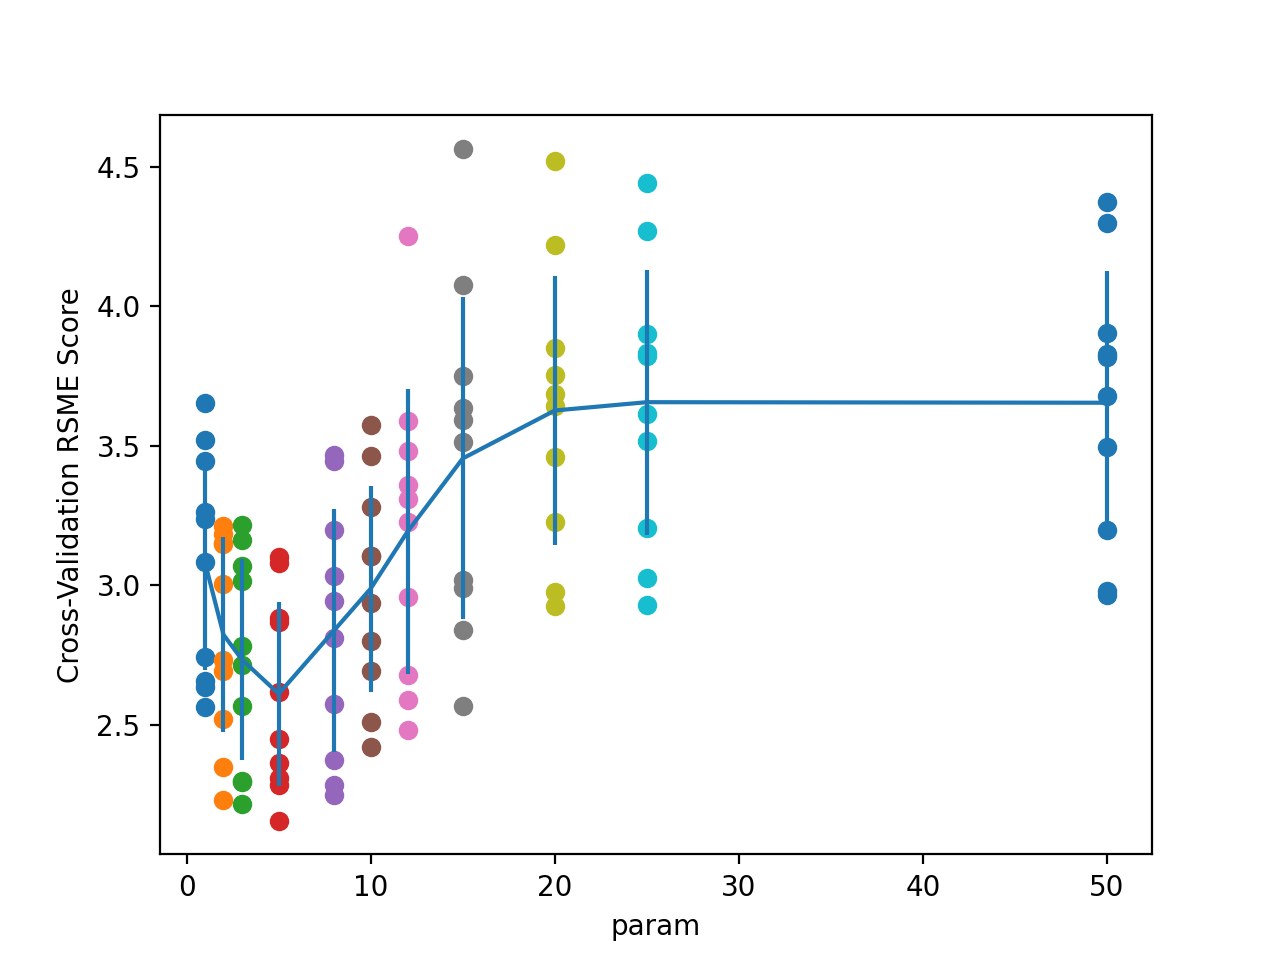

<IPython.core.display.Javascript object>


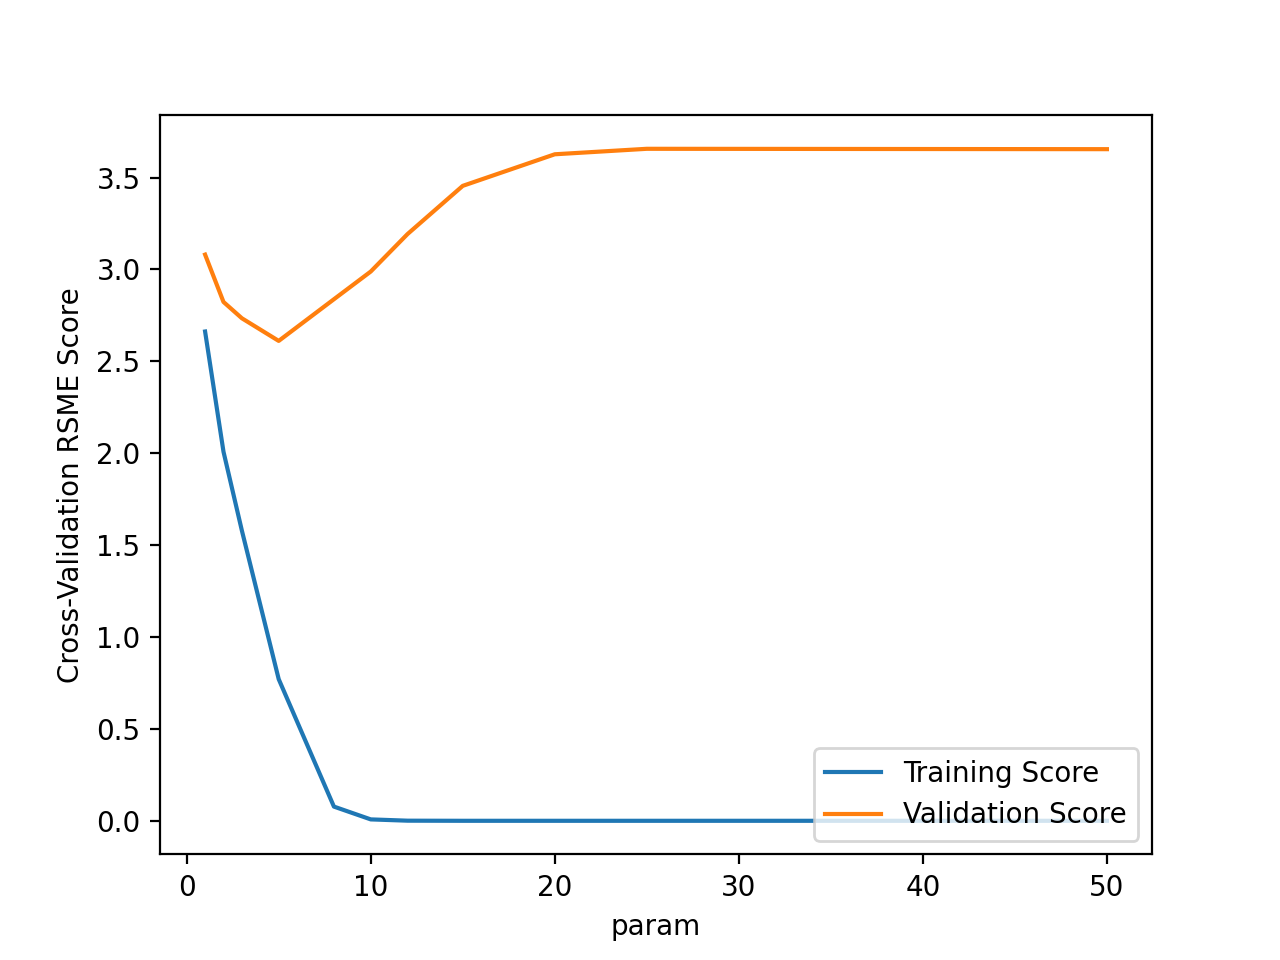

In [35]:
plot_validation_results(param_to_scores)

plot_scores(param_to_scores)

**3.2 a) Run the k-fold cross validation for all 3 regressors and compare and discuss the results! (5 Points)** You should see quite a number of differences regarding runtimes, issues of overfitting and underfitting, overall performance, effects of parameter values, etc. You can use the code cells above for cross validation and visualization.

**Your Answer:**

1. Given the same parameters, training DecisionTreeRegressor is the fastest, while training the GradientBoostingRegressor is the slowest.
2. Every regressor suffers from underfitting when the parameter is very small (such as 1 or 2 or 3).
3. The GradientBoostingRegressor suffers from overfitting after the parameter is greater than 5.
4. The RandomForestRegressor achieves the best performance over all three regressors when the parameter equals to 10.
5. When the parameter is greater than a certain value (20,10 and 25 for DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor respectively), RSME score on both training set and validation set remains stable.

**3.2 b) Discuss if we found the regressor! (3 Points)** 

**Your Answer:**

I would say yes. In this case, the RandomForestRegressor is the best regressor. The model has converged after the parameter is greater than 10 with a relatively low RSME score on both the training and validation set (0.9 and 2.7 respectively). Also, the time consuming is acceptable compared to the GradientBoostingRegressor and the DecisionTreeRegressor.